In [18]:
import os
import sys
import numpy as np
import pandas as pd
import glob
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
import torch

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load In Data

In [21]:
%%time
labels = [] #label for each image
images = []
pose_mapping = dict()
images_path = []
images_pixels = []
not_image_pose = []
not_image = []

i = 0
data_dir = "/content/drive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/img"

for pose in os.listdir(data_dir):
    pose_mapping[i] = pose
    subdir = os.path.join(data_dir,pose)
    for img in os.listdir(subdir):
        img_path = os.path.join(subdir,img)
        images_path.append(img_path)
        img_pix_bgr = cv2.imread(img_path,1)
        if img_pix_bgr is None:
            print(f"{img} in {pose} cannot be read")
            not_image_pose.append(pose)
            not_image.append(img)
            continue
        
        img_pix_rgb = cv2.cvtColor(img_pix_bgr, cv2.COLOR_BGR2RGB) 
        images_pixels.append(img_pix_rgb)
        images.append(img)
        labels.append(i)
        
    i += 1 

CPU times: user 3.71 s, sys: 296 ms, total: 4.01 s
Wall time: 27.2 s


In [22]:
print(f"Ignoring GIF,there are {len(images)} images.")

Ignoring GIF,there are 486 images.


In [23]:
label_mapping = pd.DataFrame.from_dict(pose_mapping,"index")
label_mapping = label_mapping.reset_index()
label_mapping.columns = ["label","pose"]
label_mapping.head()

,label,pose
0,0,warrior
1,1,tree
2,2,traingle
3,3,shoudler_stand
4,4,no_pose


In [27]:
import pickle

mylist = label_mapping['pose'].tolist()

with open('labeling.pkl', 'wb') as f:
   pickle.dump(mylist, f)
 

## Visualize some of the data

show first 6 images in first class

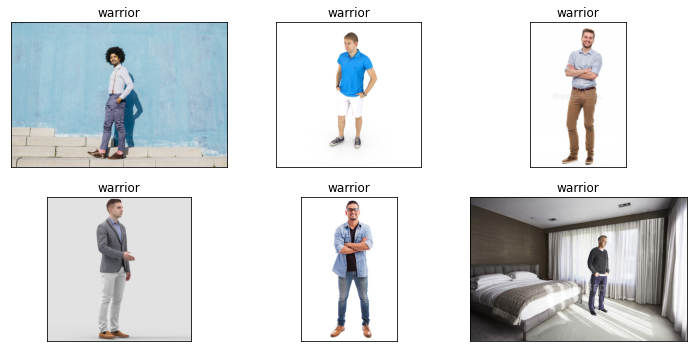

In [35]:
class_dir = '/content/drive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/img/no_pose'

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(os.path.join(class_dir, os.listdir(class_dir)[i])))
    ax.set_title(os.listdir(data_dir)[0])
plt.tight_layout()
plt.show()

In [37]:
## count number of images in each class
df_count = pd.DataFrame(columns=['class','count'])
df_count['class']=pd.Series([os.listdir(data_dir)[x] for x in range(0,4)])
df_count['count']=pd.Series([len(os.listdir(os.path.join(data_dir,os.listdir(data_dir)[x]))) for x in range(0,4)])
df_count
# df_count.sort_values(by=['count'])

,class,count
0,warrior,278
1,tree,173
2,traingle,51
3,shoudler_stand,101


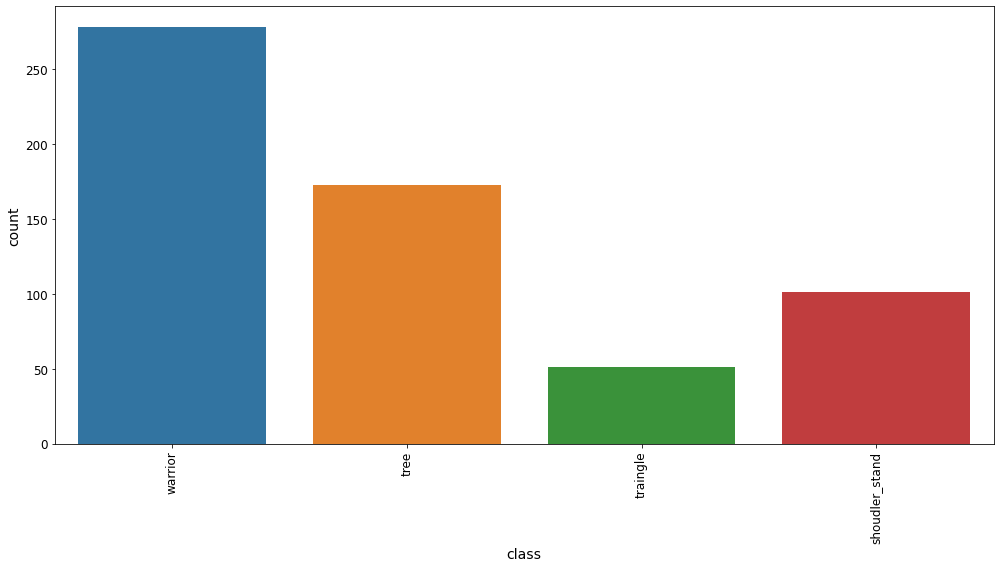

In [38]:
import seaborn as sns
plt.figure(figsize=(14,8))
g=sns.barplot(x='class', y='count', data=df_count)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()

(numpy.ndarray, dtype('float32'), (821, 1232, 3))

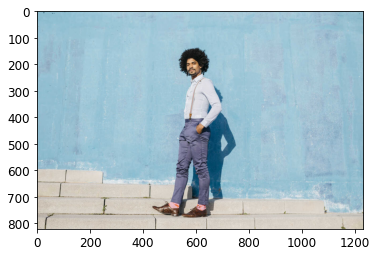

In [39]:
## display the first image in first class
first_fir = plt.imread(os.path.join(class_dir, os.listdir(class_dir)[0]))
plt.imshow(first_fir)

## print out type and shape of the image
type(first_fir), first_fir.dtype, first_fir.shape, 

(numpy.ndarray, dtype('float32'), (1813, 632, 3))

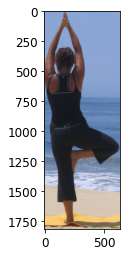

In [40]:
## display the first image in the second class
class2_dir = '/content/drive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/img/tree'

first_sec = plt.imread(os.path.join(class2_dir, os.listdir(class2_dir)[0]))
plt.imshow(first_sec)

## print out type and shape of the image
type(first_sec), first_sec.dtype, first_sec.shape, 

(numpy.ndarray, dtype('float32'), (2000, 2667, 3))

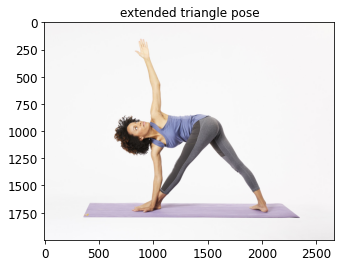

In [41]:
## display the first image in third class
class3_dir = '/content/drive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/img/traingle'

first_third = plt.imread(os.path.join(class3_dir, os.listdir(class3_dir)[0]))
plt.imshow(first_third)
plt.title('extended triangle pose')

## print out type and shape of the image
type(first_third), first_third.dtype, first_third.shape, 

Text(0.5, 1.0, 'firstInfirst Histogram')

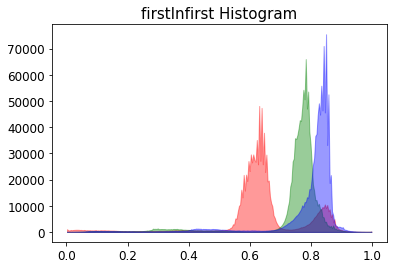

In [42]:
## plot histogram
import skimage
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate

for col, channel in zip('rgb', np.rollaxis(first_fir, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInfirst Histogram', fontsize=15)

Text(0.5, 1.0, 'firstInsecond Histogram')

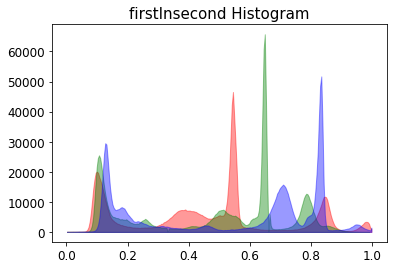

In [43]:
for col, channel in zip('rgb', np.rollaxis(first_sec, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInsecond Histogram', fontsize=15)

Text(0.5, 1.0, 'firstInthird Histogram')

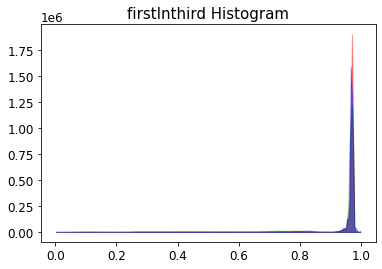

In [44]:
for col, channel in zip('rgb', np.rollaxis(first_third, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
plt.title('firstInthird Histogram', fontsize=15)

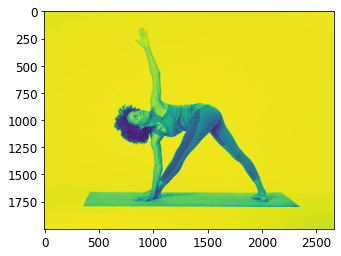

In [45]:
#convert image to grey scale and display
first_third_gray = color.rgb2gray(first_third)
plt.imshow(first_third_gray)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  


Text(0.5, 1.0, 'first_third_gray Histogram')

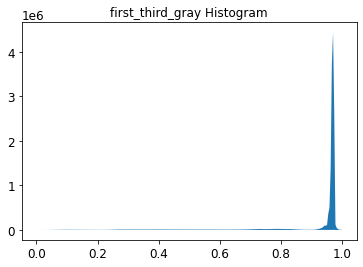

In [46]:
#plot histogram of intensities using Skimage API
hist, bin_centers = exposure.histogram(first_third)
plt.fill_between(bin_centers, hist)
plt.title("first_third_gray Histogram")

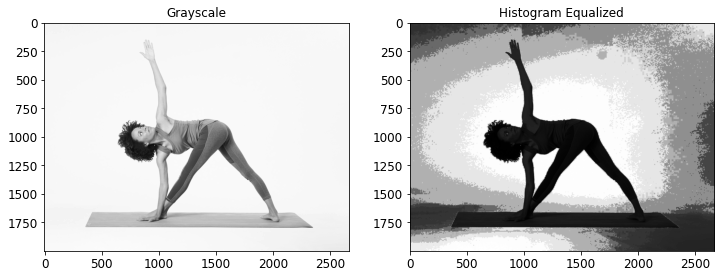

In [47]:
from skimage.exposure import equalize_hist

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

first_third_gray_equalized = equalize_hist(first_third_gray)

show_images(images=[first_third_gray, first_third_gray_equalized],
            titles=["Grayscale","Histogram Equalized"])

Text(0.5, 1.0, 'first_third_gray Equalized')

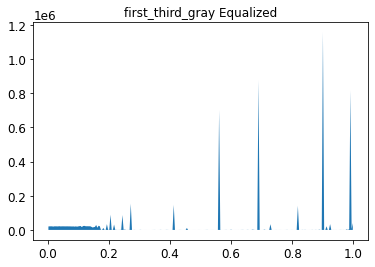

In [48]:
#plot histogram of intensities using Skimage API
hist, bin_centers = exposure.histogram(first_third_gray_equalized)
plt.fill_between(bin_centers, hist)
plt.title("first_third_gray Equalized")

Text(0.5, 1.0, 'Adaptive Histogram equalization')

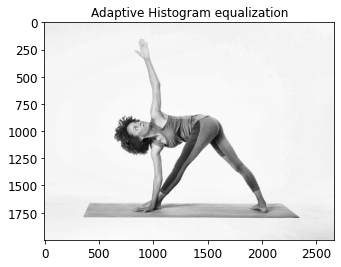

In [49]:
import cv2 as cv
img = os.path.join(class3_dir, os.listdir(class3_dir)[0])
img = cv.imread(img,0)

# create a CLAHE object
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
plt.imshow(cl1)
plt.title('Adaptive Histogram equalization')

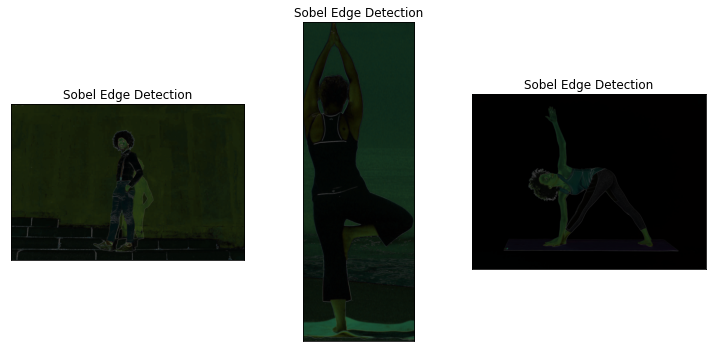

In [50]:
## Sobel Edge Detection
from skimage import filters

edge_sobel = []
img = [first_fir, first_sec, first_third]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    # edge_sobel = filters.sobel(img[j])
    ax.imshow(filters.sobel(img[i]), cmap=plt.cm.gray)
    ax.set_title('Sobel Edge Detection')

plt.tight_layout()
plt.show()

In [67]:
data_augmentation = tf.keras.Sequential(
    [keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      # keras.layers.experimental.preprocessing.RandomRotation(0.1),
      keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

Saving figure hola0
Saving figure hola1
Saving figure hola2
Saving figure hola3
Saving figure hola4
Saving figure hola5
Saving figure hola6
Saving figure hola7
Saving figure hola8
Saving figure hola9
Saving figure hola10
Saving figure hola11


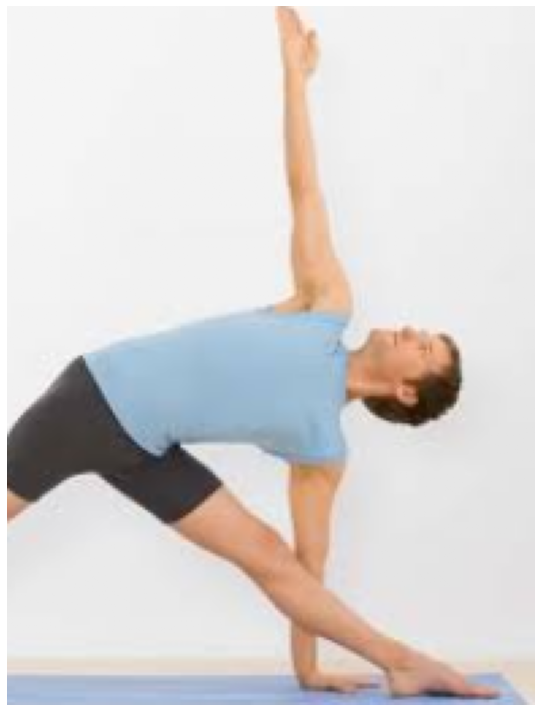

In [68]:
# Resultado de una imagen
class_dir = "/content/drive/MyDrive/Colab Notebooks/SIS330/Correcion de Poses/img/traingle"
image = plt.imread(os.path.join(class_dir, os.listdir(class_dir)[3]))
plt.figure(figsize=(10, 10))

for i in range(12):
    # plt.subplot(1, 1, i + 1) 
    augmented_image = data_augmentation(            
        tf.expand_dims(image, 0)
        )
    
    # plt.imshow(augmented_image[0])
    # plt.imshow((augmented_image[0] * 255).astype(np.uint8))
    plt.imshow(augmented_image[0])
    plt.axis("off")
    save_fig("hola"+str(i))